In [1]:
import sys
# Use this block to download extra dependencies


In [2]:
import torchvision
import torch
import pydicom as dicom

import numpy as np
import pandas as pd
from functools import partial
import rnsa

from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 1

In [4]:
models_path = '/home/tstrebel/models'
train_img_dir = '/home/tstrebel/assets/rnsa-pneumonia/train-images'
annotations_file_path = '/home/tstrebel/assets/rnsa-pneumonia/stage_2_train_labels.csv.zip'

In [5]:
label_df = pd.read_csv(annotations_file_path).groupby('patientId').first().reset_index()

X_train, X_test = train_test_split(label_df, test_size=.2, stratify=label_df.Target, random_state=99)
X_val, X_test, = train_test_split(X_test, test_size=.5, stratify=X_test.Target, random_state=99)
train_ix, val_ix, test_ix = X_train.index.tolist(), X_val.index.tolist(), (X_test.index.tolist())
del(X_train)
del(X_val)
del(X_test)
print('train {:,} - validate {:,} - test {:,}'.format(len(train_ix), len(val_ix), len(test_ix)))

train 21,347 - validate 2,668 - test 2,669


In [6]:
mean = [0.5]
std = [0.225]

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    # torchvision.transforms.RandomRotation((-5, 5)),
    torchvision.transforms.Resize(512),
    torchvision.transforms.CenterCrop(448),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std),
])

val_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(512),
    torchvision.transforms.CenterCrop(448),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std),
])

label_transform = torchvision.transforms.Compose([
    partial(torch.tensor, dtype=torch.float),
    partial(torch.unsqueeze, dim=0),
])
    
train_dataset = rnsa.RNSADataset(train_img_dir, annotations_file_path, train_ix, train_transform, label_transform)
val_dataset = rnsa.RNSADataset(train_img_dir, annotations_file_path, val_ix, val_transform, label_transform)

In [7]:
model = rnsa.Densenet121(torchvision.models.densenet121(weights='DEFAULT'))
# model = torch.load(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for param in model.features.parameters():
    param.requires_grad = False

optimizer = torch.optim.SGD(model.classifier.parameters(), lr=1e-3, momentum=.9, weight_decay=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()
lr_scheduler = rnsa.LRScheduler(optimizer)

In [34]:
model_save_path='/'.join([models_path, 'rnsa-densenet.pt'])

rnsa.train_model(model,  
                 model_save_path,
                 train_dataset, 
                 val_dataset,
                 optimizer, 
                 criterion, 
                 batch_size=32,
                 num_epochs=2,
                 )

epoch 1/2
----------
train Loss: 0.0152 Acc: 0.7646 LR: 0.001000
Training complete in 5m 55s
validation Loss: 0.0148 Acc: 0.7766 LR: 0.001000
Training complete in 6m 36s
epoch 2/2
----------
train Loss: 0.0150 Acc: 0.7719 LR: 0.001000
Training complete in 12m 20s
validation Loss: 0.0142 Acc: 0.7894 LR: 0.001000
Training complete in 12m 60s
Training complete in 13m 0s
Best val Loss: 37.890877
Best val Acc: 0.789355


In [14]:
test_dataset = rnsa.RNSADataset(train_img_dir, annotations_file_path, test_ix, train_transform, label_transform)
test_data_loader = rnsa.get_data_loader(test_dataset, batch_size=32)

with torch.no_grad():
    running_targets = torch.Tensor(0, 1).to(device)
    running_outputs = torch.Tensor(0, 1).to(device)
    
    model.eval()
    for inputs, targets in test_data_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        
        running_targets = torch.vstack((running_targets, targets))
        running_outputs = torch.vstack((running_outputs, outputs)) 

best threshold	0.4564
precision:	0.6530
recall:		0.6963
f1:		0.6739



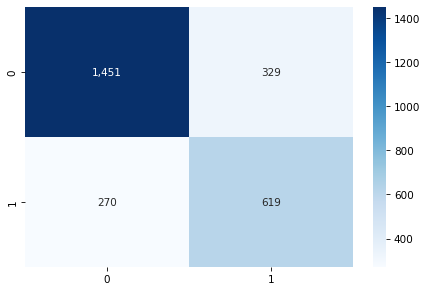

In [33]:
y_true = running_targets.cpu().numpy()
y_proba = torch.nn.Sigmoid()(running_outputs).cpu().numpy()

precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_proba)
f1_scores = (2 * precision * recall) / (precision + recall)
ix = np.argmax(f1_scores)
best_thresh = thresholds[ix]

y_pred = y_proba >= best_thresh #running_outputs.argmax(dim=1).cpu().numpy()

precision = metrics.precision_score(y_true, y_pred)
recall = metrics.recall_score(y_true, y_pred)
f1 = metrics.f1_score(y_true, y_pred)

print('best threshold\t{:.4f}'.format(best_thresh))
print('precision:\t{:.4f}'.format(precision))
print('recall:\t\t{:.4f}'.format(recall))
print('f1:\t\t{:.4f}'.format(f1))
print()

fig = plt.figure(dpi=75)
ax = plt.gca()
sns.heatmap(metrics.confusion_matrix(y_true, y_pred), annot=True, fmt=',', cmap='Blues')
fig.tight_layout()
plt.show()